In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, cohen_kappa_score, classification_report , roc_curve, roc_auc_score, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost

In [2]:
# set matplotlib defaults
%matplotlib inline
sns.set()
plt.rcParams["figure.figsize"] = (15,6)
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
plt.rc('figure', titlesize=18)
plt.style.use('seaborn-darkgrid')

In [4]:
data_2018 = pd.read_csv("../data/dataset_2018_with_negatives.csv")
data_2019 = pd.read_csv("../data/dataset_2019_with_negatives.csv")

/home/juan/anaconda3/envs/ds4a/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
# data_2018 = data_2018[(data_2018.summary.notnull())  & (data_2018.month > 8)]
data_2018 = data_2018[data_2018['summary'].isnull() == False]

In [9]:
print(data_2019.shape, data_2018.shape)

(58133, 40) (49101, 40)


In [10]:
data = pd.concat([data_2018, data_2019])

In [11]:
# data = pd.get_dummies(data, columns=['summary'])

In [12]:
# data.drop(['year', 'precipAccumulation', 'timestamp', 'date', 'address', 
#            'severity', 'accident_type','severity_numeric','borough_id',
#           'timestamp_darksky', 'summary', 'icon','precipType'], axis=1, inplace=True)

In [11]:
data.reset_index(drop=True, inplace=True)
data.index

RangeIndex(start=0, stop=107234, step=1)

In [14]:
data.columns

Index(['x', 'y', 'timestamp', 'date', 'year', 'month', 'day', 'day_of_year',
       'day_of_week', 'hour', 'address', 'severity', 'accident_type',
       'severity_numeric', 'borough', 'cluster_id', 'sample_type',
       'borough_id', 'area_km2', 'population', 'population_density',
       'timestamp_darksky', 'summary', 'icon', 'precipIntensity',
       'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint',
       'humidity', 'windSpeed', 'cloudCover', 'uvIndex', 'visibility',
       'windBearing', 'windGust', 'pressure', 'precipType', 'ozone',
       'precipAccumulation'],
      dtype='object')

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79629 entries, 0 to 79628
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   x                    79629 non-null  float64
 1   y                    79629 non-null  float64
 2   timestamp            79629 non-null  object 
 3   date                 79629 non-null  object 
 4   year                 79629 non-null  int64  
 5   month                79629 non-null  int64  
 6   day                  79629 non-null  int64  
 7   day_of_year          79629 non-null  int64  
 8   day_of_week          79629 non-null  int64  
 9   hour                 79629 non-null  int64  
 10  address              79629 non-null  object 
 11  severity             39792 non-null  object 
 12  accident_type        39792 non-null  object 
 13  severity_numeric     39792 non-null  float64
 14  borough              79629 non-null  object 
 15  cluster_id           79629 non-null 

In [12]:
corr = data.corr()
c1 = corr.abs().unstack().round(3)
c1<1
c1[(c1<1) & (c1> 0.65)].sort_values(ascending = False)

month                day_of_year            0.997
apparentTemperature  temperature            0.997
day_of_year          month                  0.997
temperature          apparentTemperature    0.997
windGust             windSpeed              0.829
windSpeed            windGust               0.829
precipProbability    precipIntensity        0.822
precipIntensity      precipProbability      0.822
uvIndex              temperature            0.812
temperature          uvIndex                0.812
apparentTemperature  uvIndex                0.801
uvIndex              apparentTemperature    0.801
humidity             temperature            0.728
temperature          humidity               0.728
apparentTemperature  humidity               0.711
humidity             apparentTemperature    0.711
temperature          hour                   0.685
hour                 temperature            0.685
apparentTemperature  hour                   0.675
hour                 apparentTemperature    0.675


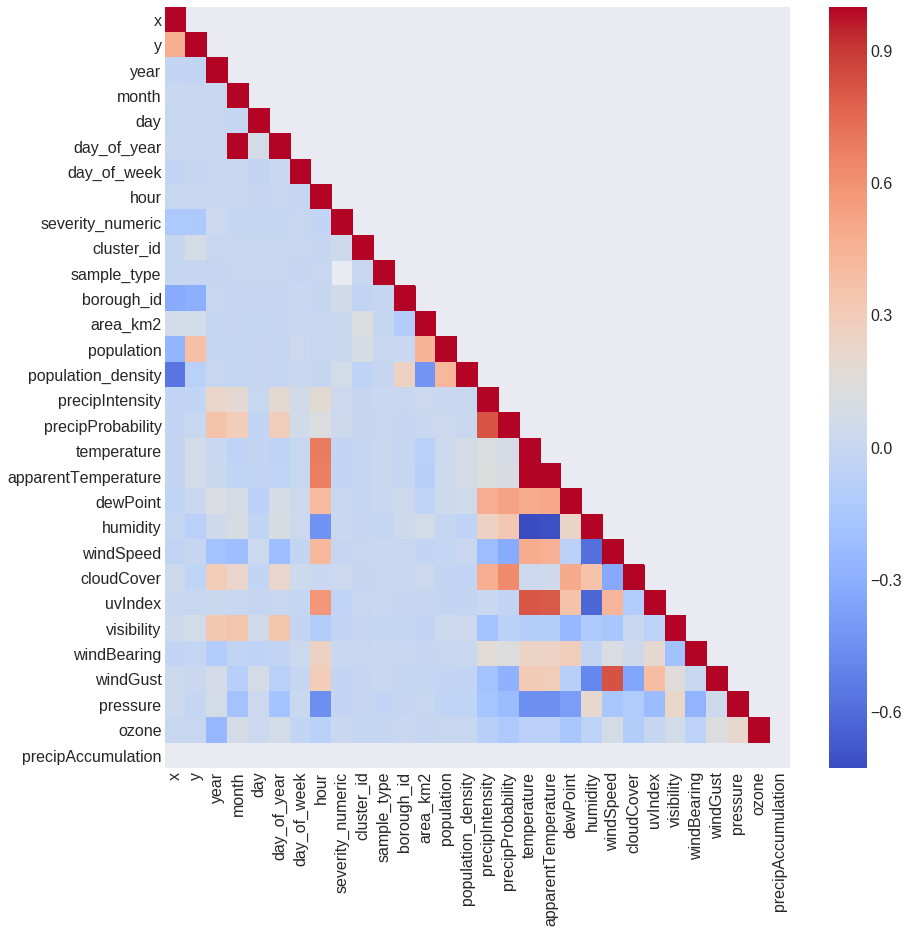

In [13]:
plt.figure(figsize=(14,14))
sns.heatmap(corr.where(np.tril(np.ones(corr.shape)).astype(np.bool)), cmap='coolwarm')
plt.show()

## Useful Functions

In [14]:
def model_fit_predict(X_train, X_test, y_train, y_test, clf):
    categories = ['non-accident', 'accident']
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring= 'roc_auc', n_jobs=-1)
    print('ROC AUC: {:.2f} (+/- {:.3f} )'.format(scores.mean(), scores.std() * 2))

    y_pred = clf.predict(X_test)
    print('Cohen kappa score {:.4f}'.format(cohen_kappa_score(y_pred, y_test)))
    print('F1 score {:.4f}'.format(f1_score(y_pred, y_test,)))
    print('Average precision score {:.4f}'.format(average_precision_score(y_pred, y_test)))
    print(classification_report(y_test, y_pred,target_names=categories))

#     metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
#     scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
#     cv = KFold(n_splits=3)
#     scv = StratifiedKFold(n_splits=3)
#     for metric in metric_names:
#         score1 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1).mean()
#         score2 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=scv, n_jobs=-1).mean()
#         scores_df.loc[metric] = [score1, score2]
#     print(scores_df)
    y_pred_proba = clf.predict_proba(X_test)[:,1]

    return clf, y_pred, y_pred_proba


In [15]:
def model_plot(y_test, y_pred, y_pred_proba, model_name):
    categories = ['non-accident', 'accident']
    gs = mpl.gridspec.GridSpec(2, 2)

    plt.figure(figsize=(14,10))
    ax = plt.subplot(gs[0, 0]) # row 0, col 0
    labels = [0,1]
    cnf_mx = confusion_matrix(y_test,y_pred,labels=labels)
    ax1 = sns.heatmap(cnf_mx, cmap='Blues',annot=True, fmt="d")
    plt.xticks([0.5,1.5],categories, rotation=0)
    plt.yticks([0.5,1.5],categories, rotation=0)
    plt.title(f'Confusion matrix {model_name}', fontsize=18)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    ax = plt.subplot(gs[0, 1]) # row 0, col 1
    row_sums = cnf_mx.sum(axis=1, keepdims=True)
    norm_cnf_mx = cnf_mx / row_sums
    np.fill_diagonal(norm_cnf_mx, 0)
    ax2 = sns.heatmap(norm_cnf_mx, cmap='Blues',annot=True, fmt=".4%")
    plt.xticks([0.5,1.5],categories, rotation=0)
    plt.yticks([0.5,1.5],categories, rotation=0)
    plt.title(f'Error matrix {model_name}', fontsize=18)
    plt.xlabel('Predicted label')

    ax = plt.subplot(gs[1, :]) # row 1, span all columns
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    # Display plot for AUC curve
    ax3 = plt.plot(fpr,tpr,label= f"{model_name}, auc={round(auc,4)}")
    ax3 = plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
    plt.legend(fontsize=14)
    plt.title(f"ROC cuve: {model_name}", fontsize= 18)
    plt.tight_layout()
    plt.show()

In [16]:
def generate_cyclical_variables(df, column, period):
    if df[column].min() != 0:
        df[f'{column}_sin'] = np.sin((df[column] - 1)*(2.*np.pi/period))
        df[f'{column}_cos'] = np.cos((df[column] - 1)*(2.*np.pi/period))
    else:
        df[f'{column}_sin'] = np.sin((df[column])*(2.*np.pi/period))
        df[f'{column}_cos'] = np.cos((df[column])*(2.*np.pi/period))

    return df

In [17]:
def generate_precipitation_intensity(df, column_intensity, column_probability):
    df['precip_intensity_probability'] = df.precipIntensity * df.precipProbability
    return df

In [18]:
# data = (data.pipe(generate_precipitation_intensity, column_intensity='precipIntensity', column_probability = 'precipProbability' )
#  .pipe(generate_cyclical_variables, column='hour', period = 24)
#  .pipe(generate_cyclical_variables, column='day_of_week', period = 7)
#  .pipe(generate_cyclical_variables, column='month', period = 12)
#  .pipe(generate_cyclical_variables, column='day_of_year', period = 365)
# )

In [19]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X.loc[:,self._feature_names ] 

In [20]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class IntensityProba( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, column_intensity, column_probability ):
        self.column_intensity = column_intensity 
        self.column_probability = column_probability
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        X.loc[:,'precip_intensity_probability'] = X[self.column_intensity] * X[self.column_probability]
        return X.drop([self.column_intensity, self.column_probability], axis=1)

In [21]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class CyclicalGenerator( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, column, period ):
        self.column = column 
        self.period = period
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        if X[self.column].min() != 0:
            X.loc[:,f'{self.column}_sin'] = np.sin((X[self.column] - 1)*(2.*np.pi/self.period))
            X.loc[:,f'{self.column}_cos'] = np.cos((X[self.column] - 1)*(2.*np.pi/self.period))
        else:
            X.loc[:,f'{self.column}_sin'] = np.sin((X[self.column])*(2.*np.pi/self.period))
            X.loc[:,f'{self.column}_cos'] = np.cos((X[self.column])*(2.*np.pi/self.period))

        return X.drop(self.column, axis=1)

In [22]:
class ExtractDateParts( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, datime_column):
        self.datime_column = datime_column 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        X.loc[:,'day_of_year'] = pd.to_datetime(X[self.datime_column]).dt.dayofyear
        X.loc[:,'day_of_week'] = pd.to_datetime(X[self.datime_column]).dt.dayofweek
        X.loc[:,'month'] = pd.to_datetime(X[self.datime_column]).dt.month
        X.loc[:,'hour'] = pd.to_datetime(X[self.datime_column]).dt.hour
  
        return   X.drop(self.datime_column, axis=1)

In [27]:
cols_front_end = ['x', 'y','timestamp']
cols_to_keep_weather = [ 
       'precipIntensity', 'precipProbability', 'temperature', 
       'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'uvIndex', 'visibility']
       # 'pressure', 'ozone']
cols_to_keep = cols_front_end + cols_to_keep_weather
target_feature = ['sample_type']

In [28]:
cols_to_keep

['x',
 'y',
 'timestamp',
 'precipIntensity',
 'precipProbability',
 'temperature',
 'dewPoint',
 'humidity',
 'windSpeed',
 'cloudCover',
 'uvIndex',
 'visibility']

In [29]:
pipeline_preprocess = Pipeline([
    ('select_cols', FeatureSelector(cols_to_keep)),
    ('date_parts', ExtractDateParts('timestamp')),
    ('cyclical_hour', CyclicalGenerator('hour', 24)),
    ('cyclical_dow', CyclicalGenerator('day_of_week', 7)),
    ('cyclical_month', CyclicalGenerator('month', 12)),
    ('cyclical_doy', CyclicalGenerator('day_of_year', 365) ),
    ('intesity_proba', IntensityProba('precipIntensity', 'precipProbability')),
])

data_prepared_df = pipeline_preprocess.fit_transform(data)

In [30]:
data_prepared_df.head(2)

,x,y,temperature,dewPoint,humidity,windSpeed,cloudCover,uvIndex,visibility,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos,precip_intensity_probability
0,-74.121790,4.603106,12.94,9.99,0.82,2.09,0.44,0.0,10.003,1.224647e-16,-1.0,-0.781831,0.62349,0.866025,0.5,0.989932,0.14154,0.0
1,-74.106312,4.627395,12.94,9.99,0.82,2.09,0.44,0.0,10.003,1.224647e-16,-1.0,-0.781831,0.62349,0.866025,0.5,0.989932,0.14154,0.0


In [31]:
full_pipeline = Pipeline([
    ('preprocess', pipeline_preprocess),
    ('scaler', MinMaxScaler()),
])

In [32]:
data_prepared = full_pipeline.fit_transform(data)

In [33]:
data_prepared
labels = data[target_feature].values

## Model

In [34]:
data_dmatrix = xgboost.DMatrix(data_prepared,label=labels,feature_names=data_prepared_df.columns)

In [35]:
X_train, X_test_val, y_train, y_test_val = train_test_split(data_prepared, labels, test_size=0.33, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.33, random_state = 42)

In [36]:
params = {'subsample': 0.8,
 'n_estimators': 300,
 'min_child_weight': 5,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 0.5,
 'colsample_bytree': 0.8}
booster = xgboost.XGBClassifier(subsample=0.8, n_estimators=300, min_child_weight=5, max_depth=8, learning_rate=0.1, gamma=0.5, colsample_bytree=0.8)
booster.fit(X_train, y_train.ravel())

categories = ['non-accident', 'accident']


y_pred_val = np.round(booster.predict(X_val))
print('\nVALIDATION\n')
print('Cohen kappa score {:.4f}'.format(cohen_kappa_score(y_pred_val, y_val)))
print('F1 score {:.4f}'.format(f1_score(y_pred_val, y_val)))
print('Average precision score {:.4f}'.format(average_precision_score(y_pred_val, y_val)))
print(classification_report(y_val, y_pred_val, target_names=categories))
y_pred_test = booster.predict(X_test)
print('\nTEST\n')
print('Cohen kappa score test {:.4f}'.format(cohen_kappa_score(y_pred_test, y_test)))
print('F1 score test {:.4f}'.format(f1_score(y_pred_test, y_test)))
print('Average Test precision score {:.4f}'.format(average_precision_score(y_pred_test, y_test)))
print(classification_report(y_test, y_pred_test, target_names=categories))
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))



VALIDATION

Cohen kappa score 0.2065
F1 score 0.5673
Average precision score 0.4777
              precision    recall  f1-score   support

non-accident       0.58      0.69      0.63      5773
    accident       0.63      0.52      0.57      5906

    accuracy                           0.60     11679
   macro avg       0.61      0.60      0.60     11679
weighted avg       0.61      0.60      0.60     11679


TEST

Cohen kappa score test 0.1989
F1 score test 0.5592
Average Test precision score 0.4735
              precision    recall  f1-score   support

non-accident       0.59      0.69      0.63     11961
    accident       0.62      0.51      0.56     11748

    accuracy                           0.60     23709
   macro avg       0.60      0.60      0.60     23709
weighted avg       0.60      0.60      0.60     23709

Test AUC: 0.5992825977925023


In [37]:
booster.predict_proba(X_val)

array([[0.6316321 , 0.36836794],
       [0.516624  , 0.48337603],
       [0.50157243, 0.49842757],
       ...,
       [0.15082109, 0.8491789 ],
       [0.47109538, 0.5289046 ],
       [0.7089985 , 0.2910015 ]], dtype=float32)

In [38]:
import joblib
# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(booster, filename)

['finalized_model.sav']

In [39]:
 #{"objective":"reg:logistic",'learning_rate': 0.2, 'gamma': 0.1, 'max_depth': 10, 'alpha': 0.1}
params = {'subsample': 0.8,
 'n_estimators': 300,
 'min_child_weight': 5,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 0.5,
 'colsample_bytree': 0.8}

cv_results = xgboost.cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=100, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [40]:
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.589871,0.004200,0.565692,0.005789
1,0.638276,0.013411,0.610319,0.016140
2,0.656144,0.004069,0.622562,0.006201
3,0.666746,0.007370,0.631141,0.007408
4,0.675759,0.006365,0.636861,0.006641
5,0.681786,0.005661,0.638643,0.008083
6,0.686034,0.005124,0.641681,0.008919
7,0.692857,0.002973,0.645863,0.008431
8,0.695537,0.003578,0.647934,0.007172
9,0.700571,0.003110,0.650082,0.006467


In [44]:
cv_results['test-auc-mean'].mean()

0.649779865

[23:20:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1588600955503/work/src/learner.cc:328: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




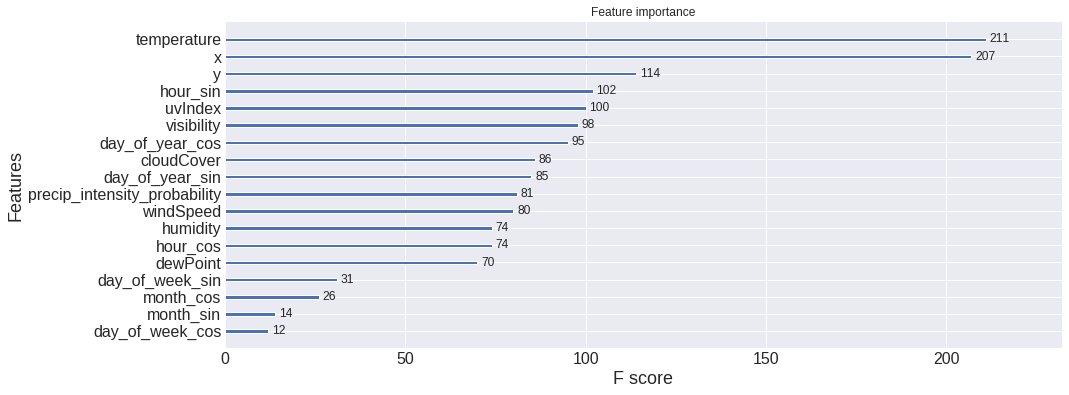

In [41]:
xg_clf = xgboost.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgboost.plot_importance(xg_clf)